In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torchvision.utils as vutils

In [9]:
ngpu = 0
img_size = 64
input_c = 100
bs = 128
device = torch.device('cuda:0' if torch.cuda.is_available() and ngpu > 0 
                      else 'cpu')
root = 'sketch_data/256x256/photo/tx_000100000000'

In [10]:
tfms = [transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize([.5, .5, .5], [.5, .5, .5])]

photo_ds = ImageFolder(root, transform=transforms.Compose(tfms))
photo_dl = DataLoader(photo_ds, batch_size=bs, shuffle=True)

In [12]:
batch = next(iter(photo_dl))

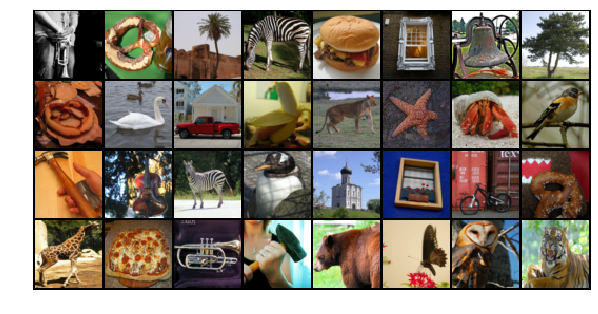

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(np.transpose(vutils.make_grid(batch[0][:32], normalize=True, 
                                         nrow=8), (1, 2, 0)))
plt.axis('off')
plt.show()

In [14]:
def conv(strided, c_in, c_out, f, stride, pad, bias=False, bn=True):
    """Create deconv block consisting of a backward strided convolution 
    optionally followed by a batch norm layer.
    """
    if strided:
        conv_ = nn.ConvTranspose2d(c_in, c_out, f, stride, pad, bias=bias)
    else:
        conv_ = nn.Conv2d(c_in, c_out, f, stride, pad, bias)
    conv_.weight.data.normal_(0.0, 0.02)
    layers = [conv_]
    if bn:
        bn_ = nn.BatchNorm2d(c_out)
        bn_.weight.data.normal_(1.0, 0.02)
        bn_.bias.data.zero_()
        layers.append(bn_)
    return nn.Sequential(*layers)

In [15]:
class Generator(nn.Module):
    
    def __init__(self, input_c=100, final_c=128):
        super().__init__()
        # 100 x 1 x 1 -> 1024 x 4 x 4
        self.deconv1 = conv(True, input_c, final_c*8, f=4, stride=1, pad=0)
        # 1024 x 4 x 4 -> 512 x 8 x 8
        self.deconv2 = conv(True, final_c*8, final_c*4, 4, 2, 1)
        # 512 x 8 x 8 -> 256 x 16 x 16
        self.deconv3 = conv(True, final_c*4, final_c*2, 4, 2, 1)
        # 256 x 16 x 16 -> 128 x 32 x 32
        self.deconv4 = conv(True, final_c*2, final_c, 4, 2, 1)
        # 128 x 32 x 32 -> 3 x 64 x 64
        self.deconv5 = conv(True, final_c, 3, 4, 2, 1, bn=False)
        
        # Convenience attributes
        self.dims = [p.shape for p in self.parameters()]
        self.trainable = [p.requires_grad for p in self.parameters()]
        self.layer_stats = [(round(p.data.mean().item(), 3), 
                             round(p.data.std().item(), 3))
                            for p in self.parameters()]
        
    def forward(self, x):
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv3(x))
        x = F.relu(self.deconv4(x))
        x = torch.tanh(self.deconv5(x))
        return x

In [21]:
class Discriminator(nn.Module):
    
    def __init__(self, dim_1=64, leak=.02):
        """
        Parameters
        -----------
        dim_1: int
            # of filters in first conv layer.
        leak: float
            Slope of leaky relu where x < 0.
        """
        super().__init__()
        self.leak = leak
        
        # 3 x 64 x 64 -> 64 x 32 x 32
        self.conv1 = conv(True, 3, dim_1, f=4, stride=2, pad=1, bn=False)
        # 64 x 32 x 32 -> 128 x 16 x 16
        self.conv2 = conv(True, dim_1, dim_1*2, 4, 2, 1)
        # 128 x 16 x 16 -> 256 x 8 x 8
        self.conv3 = conv(True, dim_1*2, dim_1*4, 4, 2, 1)
        # 256 x 8 x 8 -> 512 x 4 x 4
        self.conv4 = conv(True, dim_1*4, dim_1*8, 4, 2, 1)
        # 512 x 4 x 4 -> 1 x 1 x 1
        self.conv5 = conv(True, dim_1*8, 1, 4, 1, 0, bn=False)
        
        # Convenience attributes
        self.dims = [p.shape for p in self.parameters()]
        self.trainable = [p.requires_grad for p in self.parameters()]
        self.layer_stats = [(round(p.data.mean().item(), 3), 
                             round(p.data.std().item(), 3))
                             for p in self.parameters()]
        
    def forward(self, x):
        x = F.leaky_relu_(self.conv1(x), self.leak)
        x = F.leaky_relu_(self.conv2(x), self.leak)
        x = F.leaky_relu_(self.conv3(x), self.leak)
        x = F.leaky_relu_(self.conv4(x), self.leak)
        x = F.sigmoid(self.conv5(x))
        return x

In [22]:
g = Generator(input_c=100).to(device)

In [23]:
d = Discriminator().to(device)

In [24]:
x_tmp = torch.randn(8, 100, 1, 1)
g(x_tmp).shape

torch.Size([8, 3, 64, 64])

In [25]:
def train(d, g, epochs, dl, lr=2e-4, b1=.5, b2=.999):
    criterion = nn.BCELoss()
    d_optim = torch.optim.Adam(d.parameters(), lr=lr, betas=(b1, b2))
    g_optim = torch.optim.Adam(g.parameters())
    fixed_noise = torch.randn(64, 100, 1, 1, device=device)
    
    # Train D and G.
    for epoch in range(epochs):
        d.train()
        g.train()
        for x, y in dl:
            x = x.to(device)
            y = y.to(device)
            bs = x.shape[0]
            real_labels = torch.ones(bs, device=device)
            fake_labels = torch.zeros(bs, device=device)
            noise = torch.randn(bs, 100, 1, 1, device=device)
            
            print(epoch, bs)
            
            # Train discriminator.
            d_optim.zero_grad()
            fake = g(noise)
            d_loss_real = criterion(d(x), real_labels)
            d_loss_fake = criterion(d(fake), fake_labels)
            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            d_optim.step()
            
            print(d_loss)
            
            # Train generator. Use true_labels because we want to fool D.
            g_optim.zero_grad()
            g_loss = criterion(d(g(noise)), real_labels)
            g_loss.backward()
            g_optim.step()
        
        # Print losses.
        print(f'Epoch [{epoch+1}/{epochs}])')
        print(f'D loss (real): {d_loss_real:.4f}')
        print(f'D loss (fake): {d_loss_fake:.4f}')
        print(f'G loss: {g_loss:.4f}')

In [ ]:
train(d, g, 1, photo_dl)

0 128


In [ ]:
len(photo_ds)